<a href="https://colab.research.google.com/github/mtwenzel/teaching/blob/master/TFP_from_regression_to_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Legal
This code (C) Fraunhofer MEVIS, 2019
The code uses examples provided by Alessandro Angioi (https://www.angioi.com/tensorflow-heteroscedasticity/), which in turn have been modified from TF Probability's original authors, as described in this post: https://medium.com/tensorflow/regression-with-probabilistic-layers-in-tensorflow-probability-e46ff5d37baf

The code for the latter is available in the original TF GitHub. https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb

In [0]:
#@title Install required libraries {display-mode:'form'}
! pip install tensorflow==2.0.0-beta1
! pip install tensorflow-probability

In [0]:
#@title Imports. {display-mode:'form'}
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

from google.colab import files

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

We create a simple joint distribution, where the scale of the Gaussian depends on the location on the x axis. 

In [0]:
#@title Parameters for the simulation {display-mode:'form', run: 'auto'}

#@markdown How many samples to draw from distribution
num_samples = 5500 #@param {type: 'slider', min: 1000, max: 10000, step: 500}
#@markdown Scale of the Gaussian depends on x axis location; this is an additive component:
min_scale = 3 #@param
low = -25 #@param {type: 'slider', min: -50, max: -1, step: 1}
high = 50 #@param {type: 'slider', min: -1, max: 100, step: 1}

In [0]:
joint = tfd.JointDistributionSequential([
                 tfd.Uniform(low=low, high=high),
      lambda x : tfd.Normal(loc=x, scale=abs(x)+min_scale)
])

In [0]:
X, Y = joint.sample(num_samples)
X = X.numpy().reshape(-1,1)
Y = Y.numpy().reshape(-1,1)

Text(0, 0.5, 'Y')

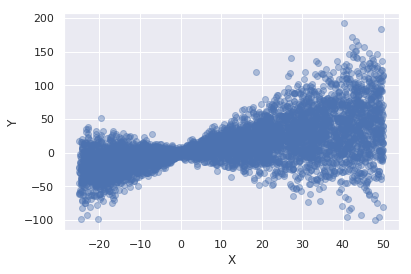

In [80]:
#@title Plot {display-mode:'form'}
plt.scatter(X,Y, alpha=0.4)
plt.xlabel('X')
plt.ylabel('Y')
#plt.savefig("scatter.svg")
#files.download('scatter.svg')

## Linear regression in TF

In [0]:
model = tf.keras.Sequential([
            tf.keras.layers.Dense(1)
])

model.compile(optimizer=tf.optimizers.Adam(learning_rate = 0.1),
              loss='mean_squared_error')

model.fit(X, Y, epochs=40);

In [0]:
#@title Plot {display-mode:'form'}
plt.scatter(X,Y, alpha=0.4)
plt.plot(X, model.predict(X), color = "red")
plt.xlabel('X')
plt.ylabel('Y')
#plt.savefig("linreg.svg")

#files.download('linreg.svg')

## Global uncertainty

Model the global model uncertainty using two parameters in the dense layer to account for the two outputs: mean and standard deviation.

In [0]:
model = tf.keras.Sequential([
            tf.keras.layers.Dense(2),
            tfp.layers.DistributionLambda(lambda t:
                tfd.Normal(loc   = t[...,:1],
#                           scale=tf.math.softplus(0.005*t[...,1:])+0.001) # Linear uncertainty
                           scale=tf.exp(0.005*t[...,1:])+0.001) # Exponential uncertainty
            )
])

negloglik = lambda y, p_y: -p_y.log_prob(y)

model.compile(optimizer=tf.optimizers.Adam(learning_rate = 0.1),
              loss=negloglik)

model.fit(X, Y, epochs=200);

Text(0, 0.5, 'Y')

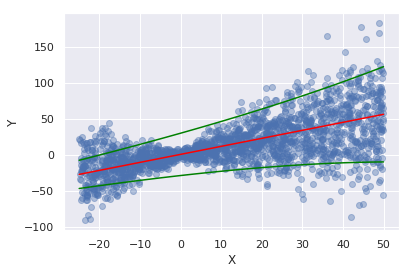

In [72]:
#@title Plot {display-mode:'form'}

x = np.linspace(low,high).reshape(-1,1)
y = model(x)

plt.scatter(X,Y, alpha=0.4)
plt.plot(x, y.mean(), color = "red");
plt.plot(x, y.mean() + 2 * y.stddev(), color = "green");
plt.plot(x, y.mean() - 2 * y.stddev(), color = "green");
plt.xlabel('X')
plt.ylabel('Y')

#plt.savefig("conf1.svg")
#files.download('conf1.svg')

## Introducing nonlinear uncertainty

We now model the nonlinear dependency of the uncertainty by introducing more degrees of freedom in the network (additional Dense layer) with a nonlinear activation.

Here are some suggestions what to explore after that.

* Observe what happens when you change the scale of the Normal distribution to be allowed to go linearly with the x axis, versus going exponentially.
* Replace `scale=tf.math.softplus(0.005*t[...,1:])+0.001)` with `scale=tf.exp(0.005*t[...,1:])+0.001)` and run the example again.
* Change the range of the example data. Originally, it is set to the interval [-8, 15]. Change it to [-50, 50] and run the experiment again.

In [0]:
model = tf.keras.Sequential([
            tf.keras.layers.Dense(20,activation="relu"),    
            tf.keras.layers.Dense(2),
            tfp.layers.DistributionLambda(lambda t:
                tfd.Normal(loc   = t[...,:1],
#                           scale=tf.math.softplus(0.005*t[...,1:])+0.001)
                           scale=tf.exp(0.005*t[...,1:])+0.001)
            )
])

negloglik = lambda y, p_y: -p_y.log_prob(y)

model.compile(optimizer=tf.optimizers.Adam(learning_rate = 0.05),
              loss=negloglik)

model.fit(X, Y, epochs=100);

Text(0, 0.5, 'Y')

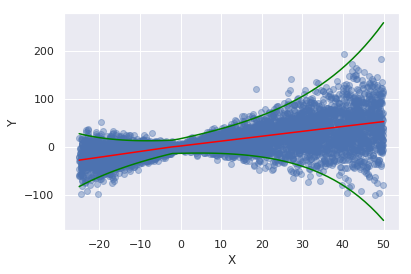

In [82]:
#@title Plot {display-mode:'form'}

x = np.linspace(low,high).reshape(-1,1)
y = model(x)

plt.scatter(X,Y, alpha=0.4)
plt.plot(x, y.mean(), color = "red");
plt.plot(x, y.mean() + 2 * y.stddev(), color = "green");
plt.plot(x, y.mean() - 2 * y.stddev(), color = "green");

plt.xlabel('X')
plt.ylabel('Y')
#plt.savefig("conf2.svg")

#files.download('conf2.svg')